<a href="https://colab.research.google.com/github/Vigneshgithub01/Email_CTR_prediction/blob/main/Email_marketing_campaign_CTR_improvement_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Email Campaign CTR Prediction - Full Comparison with Sampling, Tuning, and Threshold Analysis**

This code compares three models (Logistic Regression, Random Forest, XGBoost) using:
1. Original imbalanced data
2. SMOTE (oversampling)
3. Random Undersampling

Each model is trained:
- Without tuning (default)
- With hyperparameter tuning (GridSearchCV)

Then for the best model (LogisticRegression with SMOTE + tuning), threshold tuning from 0.5 to 0.1 is done.

Metrics compared:
- Accuracy, Precision, Recall, F1, ROC AUC
- Confusion Matrix for each case

In [6]:
from google.colab import files
uploaded = files.upload()


Saving email_opened_table.csv to email_opened_table.csv
Saving email_table.csv to email_table.csv
Saving link_clicked_table.csv to link_clicked_table.csv


In [8]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Show all columns
pd.set_option('display.max_columns', None)

In [9]:
# Load and merge all datasets
df_email = pd.read_csv("email_table.csv")
df_opened = pd.read_csv("email_opened_table.csv")
df_clicked = pd.read_csv("link_clicked_table.csv")

# Add flags
df_email['opened'] = df_email['email_id'].isin(df_opened['email_id']).astype(int)
df_email['clicked'] = df_email['email_id'].isin(df_clicked['email_id']).astype(int)

df = df_email.copy()
total_emails_sent = len(df)
total_opened = df['opened'].sum()
total_clicked = df['clicked'].sum()

open_rate = (total_opened / total_emails_sent) * 100
ctr = (total_clicked / total_emails_sent) * 100

print(f"Open Rate: {open_rate:.2f}%")
print(f"Click-through Rate (CTR): {ctr:.2f}%")

Open Rate: 10.35%
Click-through Rate (CTR): 2.12%


In [11]:
# Define features (exclude email_id and opened)
X = df.drop(columns=['email_id', 'clicked', 'opened'])
y = df['clicked']

# Column Types
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

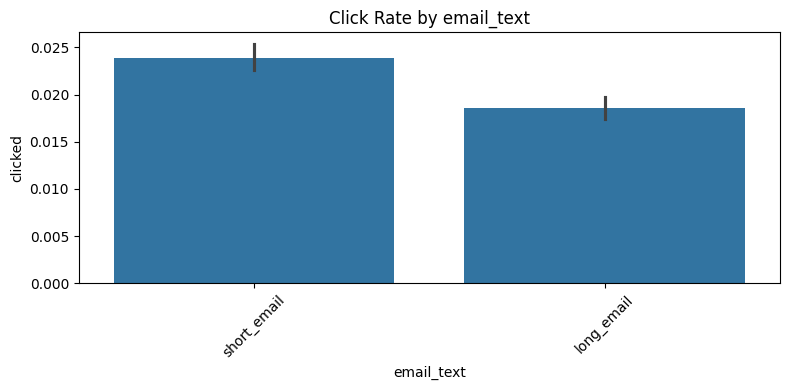

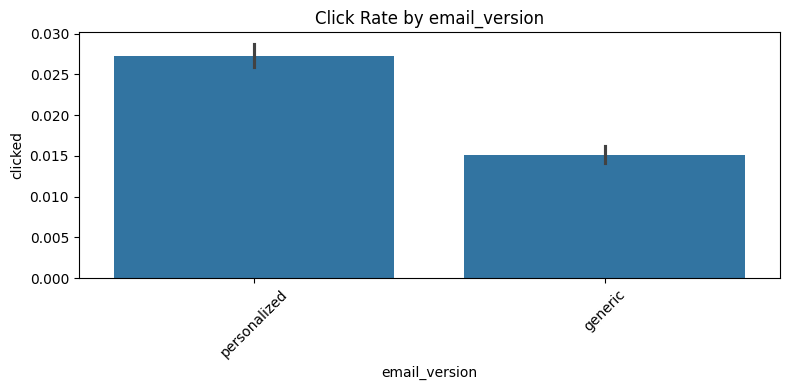

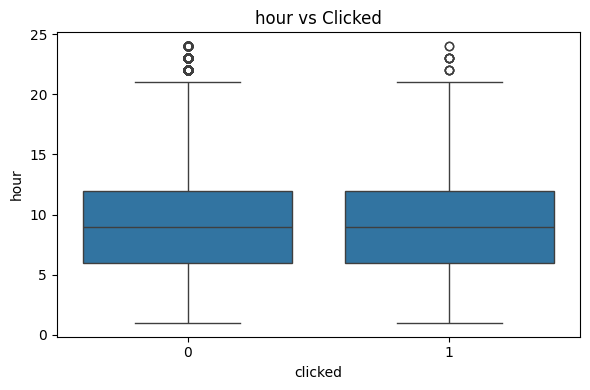

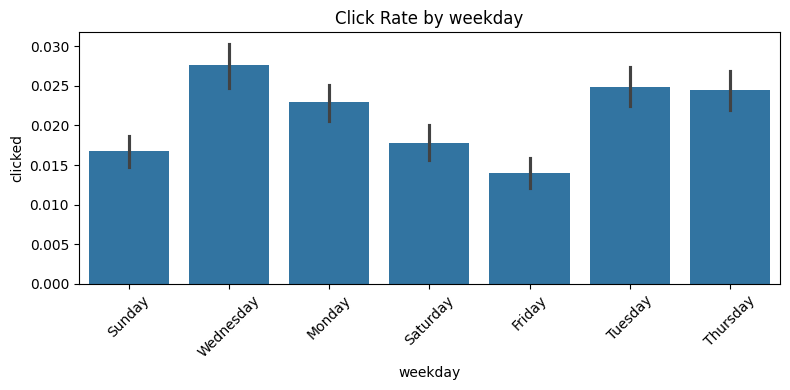

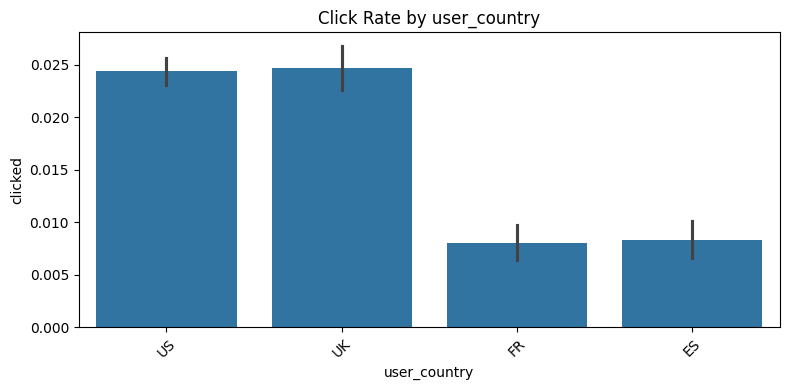

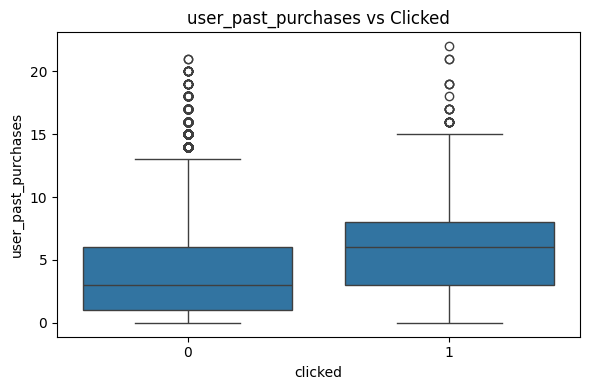

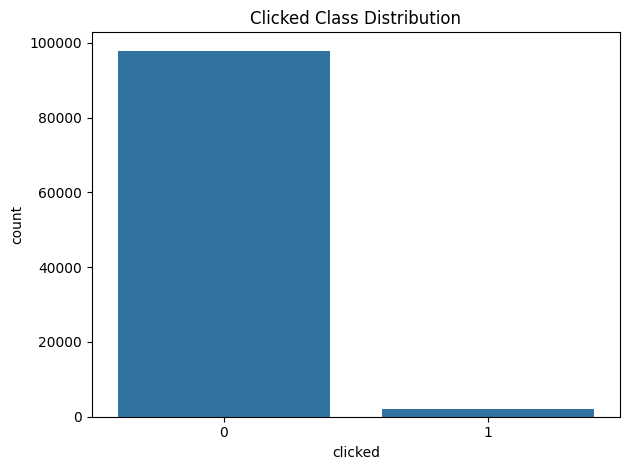

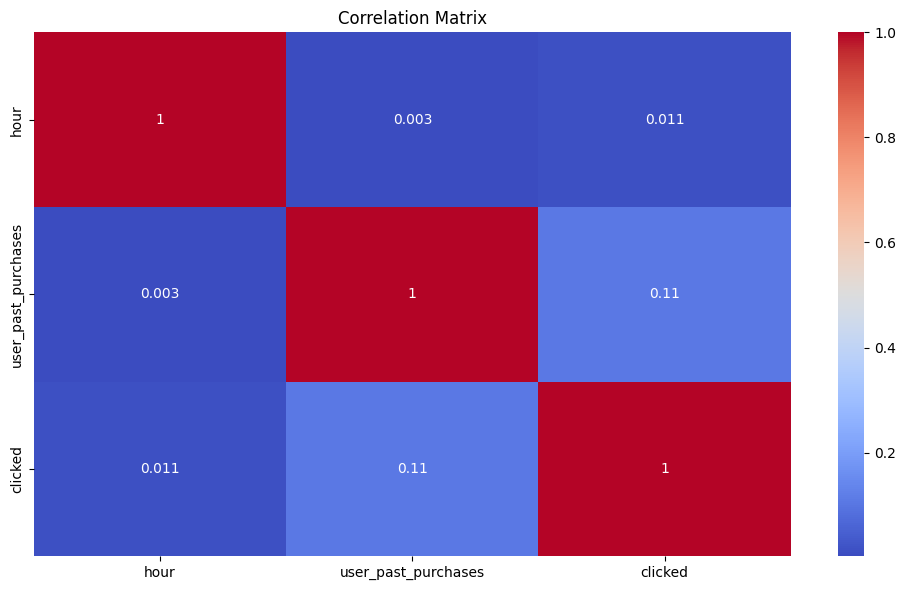

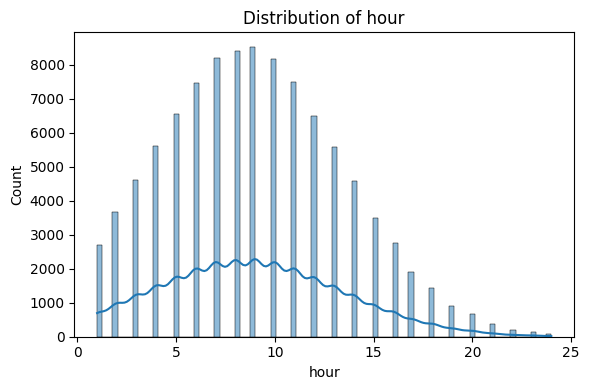

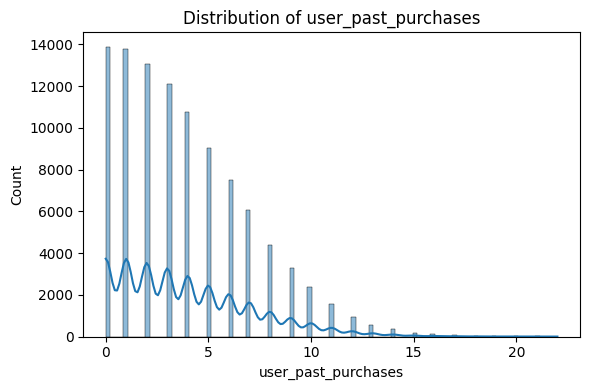

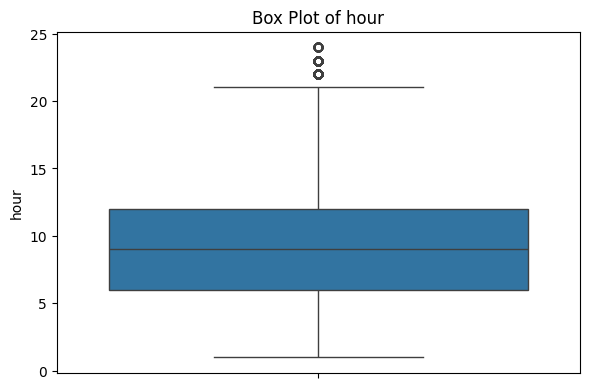

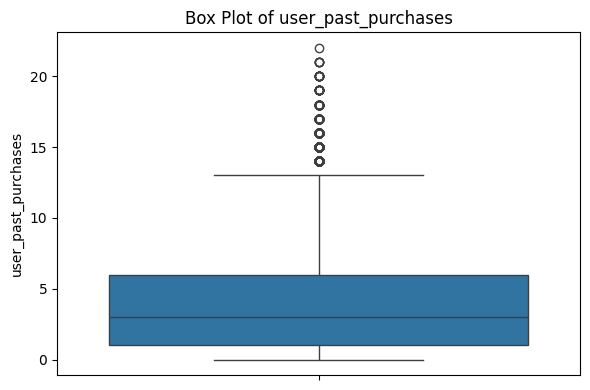

In [12]:
# === EDA ===

# 1. Clicked vs All Categorical and Numerical Columns
for col in X.columns:
    if df[col].dtype == 'object':
        plt.figure(figsize=(8, 4))
        sns.barplot(x=col, y='clicked', data=df)
        plt.title(f'Click Rate by {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='clicked', y=col, data=df)
        plt.title(f'{col} vs Clicked')
        plt.tight_layout()
        plt.show()

# 2. Clicked Imbalance Check
sns.countplot(x='clicked', data=df)
plt.title('Clicked Class Distribution')
plt.tight_layout()
plt.show()

# 3. Correlation Matrix (Numerical Columns)
plt.figure(figsize=(10, 6))
corr = df[num_cols + ['clicked']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 4. Distribution of Numerical Columns
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# 5. Box Plots of Numerical Columns
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

In [13]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Models
base_models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Hyperparameter grids
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    'XGBoost': {
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__n_estimators': [100],
        'classifier__scale_pos_weight': [(y == 0).sum() / (y == 1).sum()]
    }
}

# Sampling methods
samplers = {
    'Original': None,
    'SMOTE': SMOTE(random_state=42),
    'Undersampling': RandomUnderSampler(random_state=42)
}

In [14]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Results storage
metric_results = []
confusion_matrices = []

# Run all combinations
for model_name, model in base_models.items():
    for sampling_name, sampler in samplers.items():
        pipe = ImbPipeline([
            ('preprocess', preprocessor),
            ('sampler', sampler) if sampler else ('identity', 'passthrough'),
            ('classifier', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]

        metric_results.append({
            'Model': model_name,
            'Sampling': sampling_name,
            'Type': 'Base',
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC_AUC': roc_auc_score(y_test, y_proba)
        })
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append({
            'Model': model_name,
            'Sampling': sampling_name,
            'Type': 'Base',
            'TN': cm[0][0], 'FP': cm[0][1], 'FN': cm[1][0], 'TP': cm[1][1]
        })

        # Hyperparameter tuning
        grid = GridSearchCV(pipe, param_grids[model_name], cv=3, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]

        metric_results.append({
            'Model': model_name,
            'Sampling': sampling_name,
            'Type': 'Tuned',
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC_AUC': roc_auc_score(y_test, y_proba)
        })
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append({
            'Model': model_name,
            'Sampling': sampling_name,
            'Type': 'Tuned',
            'TN': cm[0][0], 'FP': cm[0][1], 'FN': cm[1][0], 'TP': cm[1][1]
        })

In [15]:
# Convert to DataFrames
df_metrics = pd.DataFrame(metric_results)
df_cm = pd.DataFrame(confusion_matrices)

df_metrics[['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']] *= 100

print("\n--- Model Metrics Comparison ---")
print(df_metrics[['Model', 'Sampling', 'Type', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']])

print("\n--- Confusion Matrix Comparison ---")
print(df_cm[['Model', 'Sampling', 'Type', 'TN', 'FP', 'FN', 'TP']])



--- Model Metrics Comparison ---
                 Model       Sampling   Type  Accuracy  Precision     Recall  \
0   LogisticRegression       Original   Base    68.240   4.357869  66.745283   
1   LogisticRegression       Original  Tuned    68.310   4.395435  67.216981   
2   LogisticRegression          SMOTE   Base    67.870   4.364355  67.688679   
3   LogisticRegression          SMOTE  Tuned    68.205   4.395267  67.452830   
4   LogisticRegression  Undersampling   Base    67.680   4.380665  68.396226   
5   LogisticRegression  Undersampling  Tuned    67.680   4.380665  68.396226   
6         RandomForest       Original   Base    89.205   3.385277  14.858491   
7         RandomForest       Original  Tuned    73.675   4.441935  55.660377   
8         RandomForest          SMOTE   Base    95.890   4.357798   4.481132   
9         RandomForest          SMOTE  Tuned    73.050   4.490469  57.783019   
10        RandomForest  Undersampling   Base    61.620   3.548552  65.330189   
11    

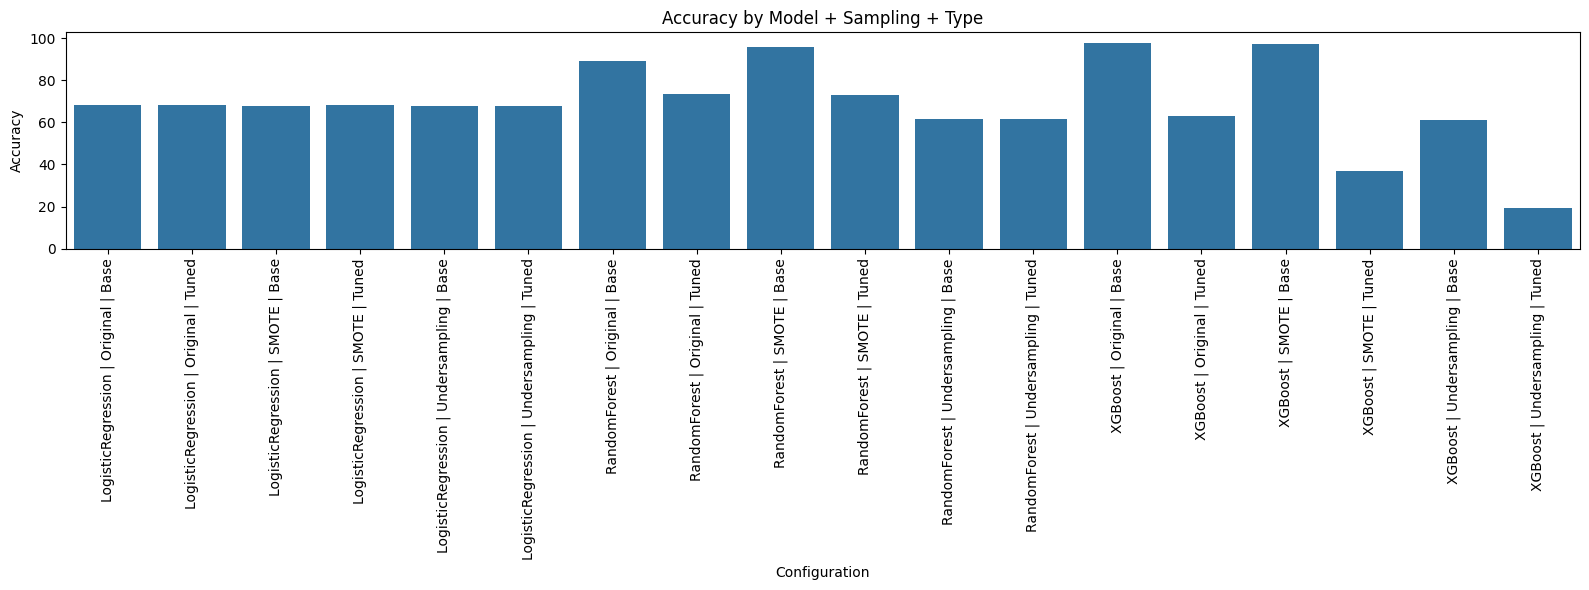

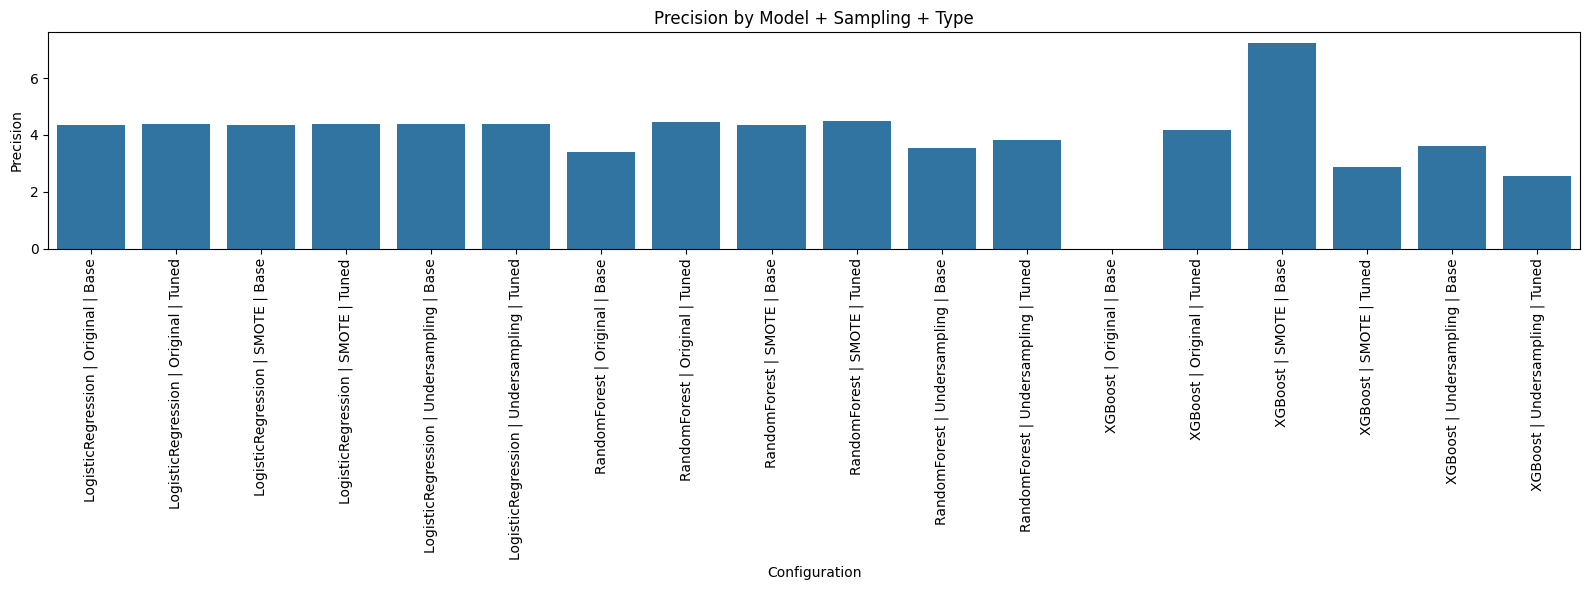

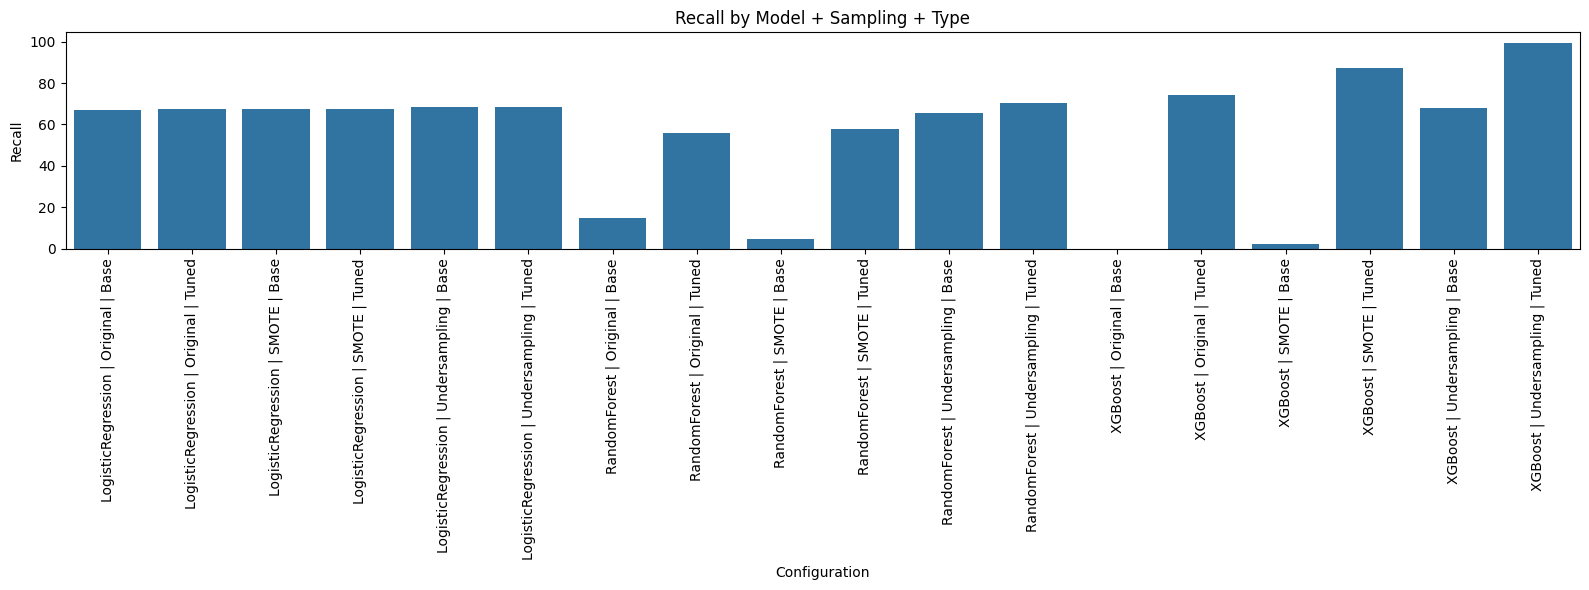

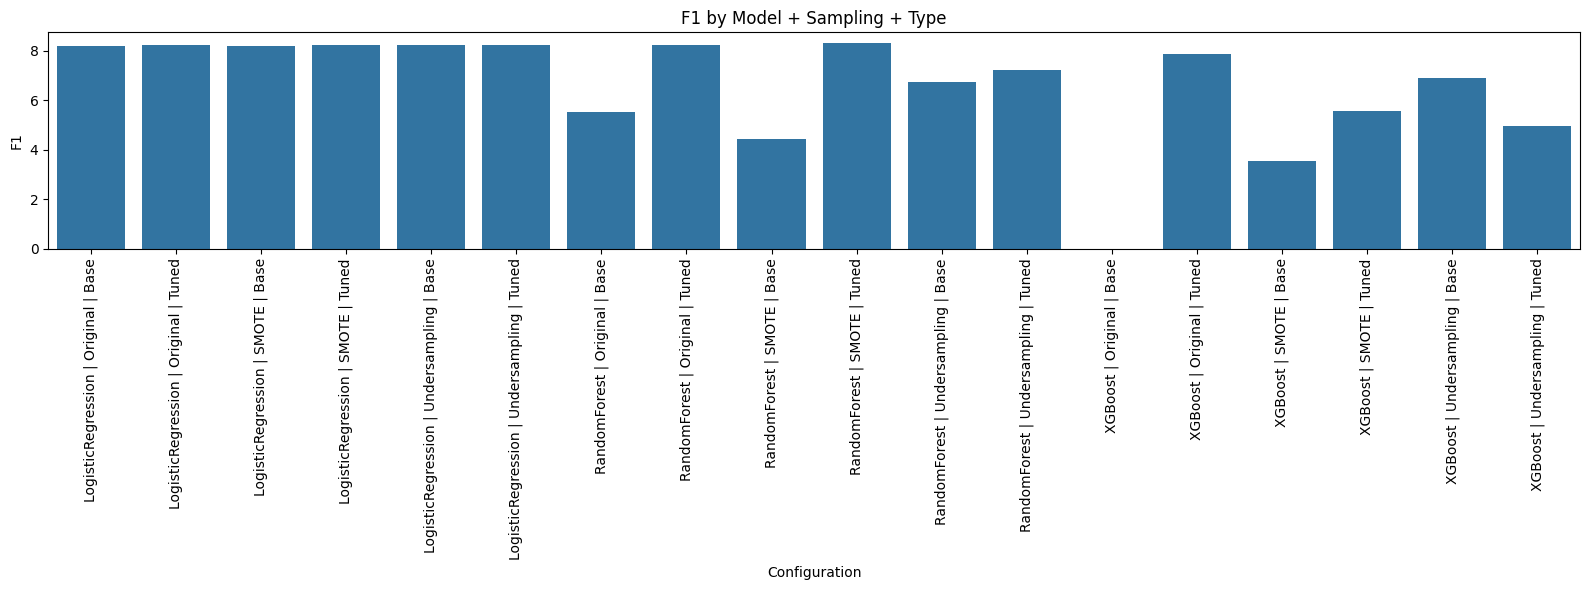

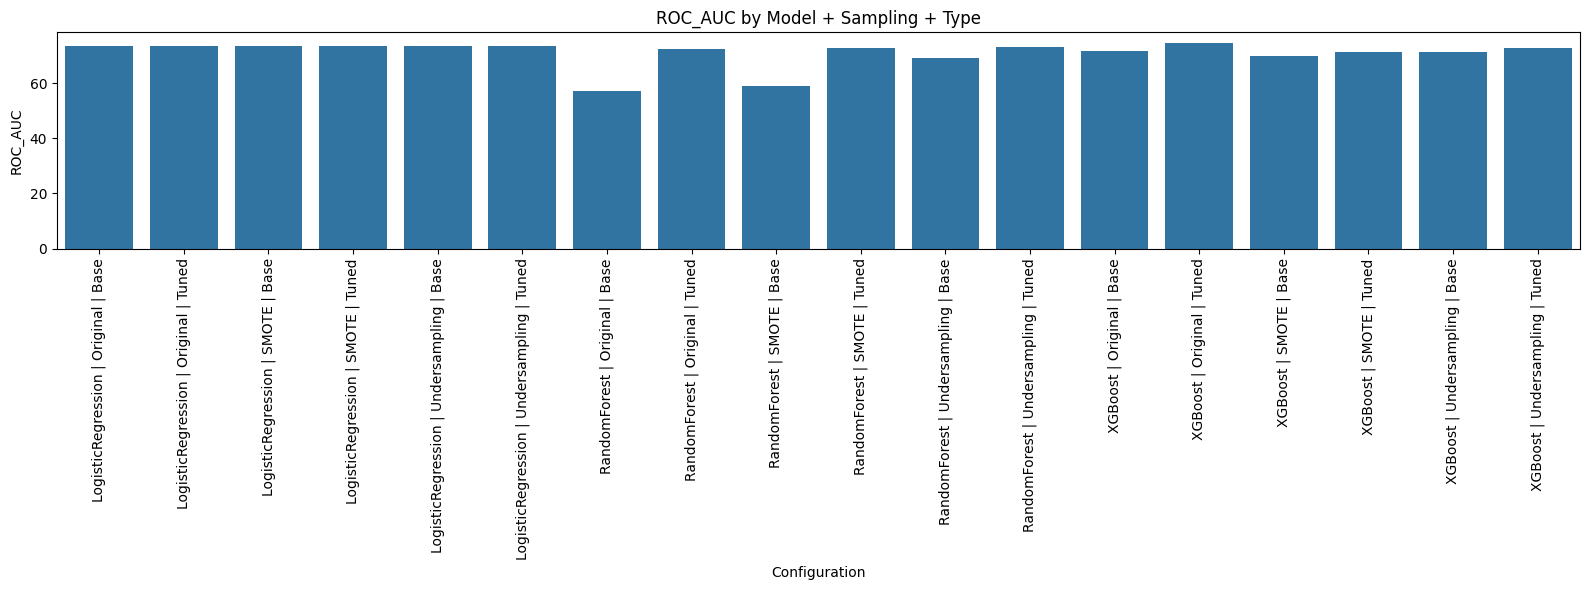

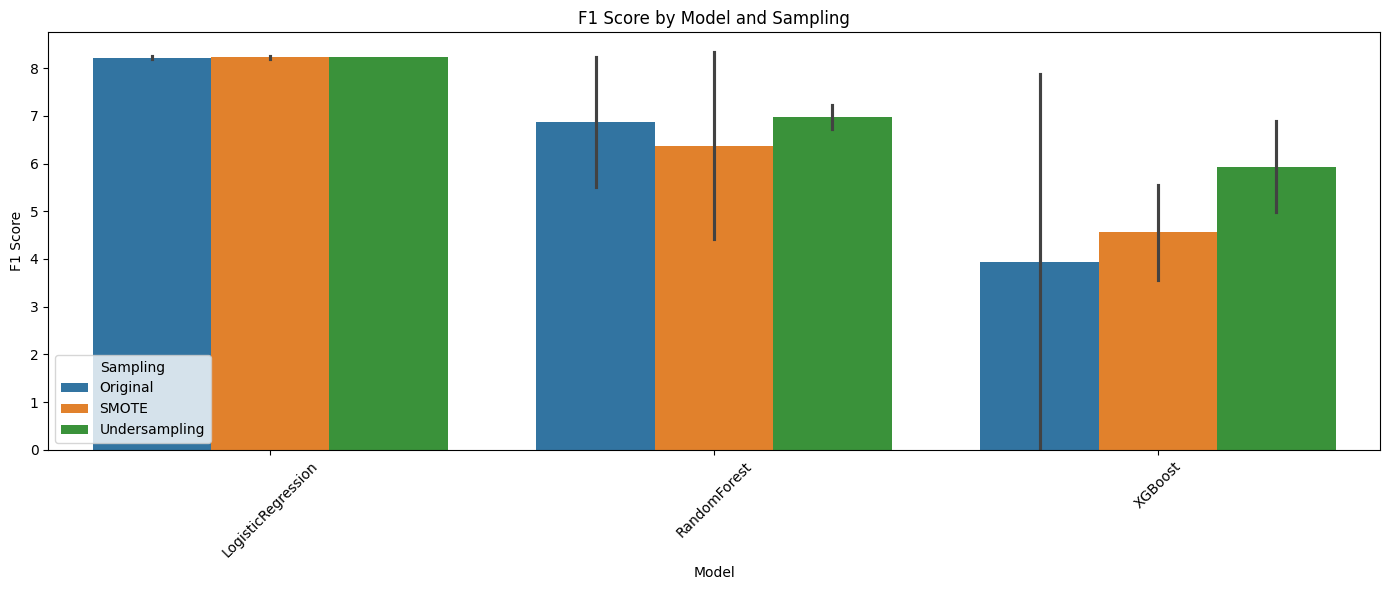

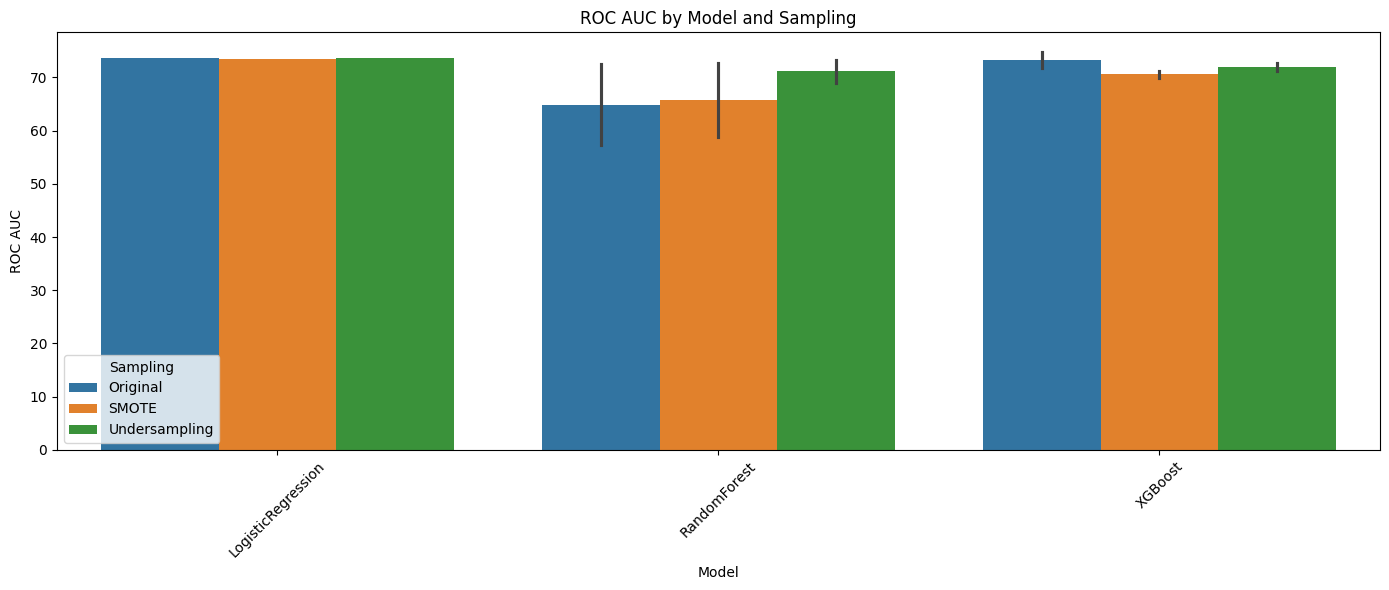

In [16]:
# === Visualization: Metrics Comparison ===
# Combine Model, Sampling, and Type to one label for better plotting
df_metrics['Config'] = df_metrics['Model'] + ' | ' + df_metrics['Sampling'] + ' | ' + df_metrics['Type']

# Plot all key metrics side by side
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
for metric in metrics_to_plot:
    plt.figure(figsize=(16, 6))
    sns.barplot(data=df_metrics, x='Config', y=metric)
    plt.title(f'{metric} by Model + Sampling + Type')
    plt.ylabel(metric)
    plt.xlabel('Configuration')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=df_metrics, x='Model', y='F1', hue='Sampling')
plt.title('F1 Score by Model and Sampling')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.legend(title='Sampling')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=df_metrics, x='Model', y='ROC_AUC', hue='Sampling')
plt.title('ROC AUC by Model and Sampling')
plt.ylabel('ROC AUC')
plt.xlabel('Model')
plt.legend(title='Sampling')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Threshold tuning for best model (LogReg + SMOTE + Tuned)
print("\n--- Threshold Tuning (Logistic Regression with SMOTE + Tuning) ---")
best_lr_smote = GridSearchCV(ImbPipeline([
    ('preprocess', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42))
]), param_grids['LogisticRegression'], cv=3, scoring='f1', n_jobs=-1)

best_lr_smote.fit(X_train, y_train)
best_model = best_lr_smote.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

threshold_metrics = []
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    threshold_metrics.append({
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba),
        'TN': cm[0][0], 'FP': cm[0][1], 'FN': cm[1][0], 'TP': cm[1][1]
    })

# Display threshold tuning results
df_threshold = pd.DataFrame(threshold_metrics)
df_threshold[['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']] *= 100
print("\n--- Threshold Tuning Metrics Table ---")
print(df_threshold[['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']])

print("\n--- Threshold Tuning Confusion Matrix Table ---")
print(df_threshold[['Threshold', 'TN', 'FP', 'FN', 'TP']])


--- Threshold Tuning (Logistic Regression with SMOTE + Tuning) ---

--- Threshold Tuning Metrics Table ---
   Threshold  Accuracy  Precision      Recall        F1    ROC_AUC
0        0.5    68.205   4.395267   67.452830  8.252777  73.492992
1        0.4    51.515   3.444121   80.896226  6.606954  73.492992
2        0.3    33.670   2.869935   92.216981  5.566629  73.492992
3        0.2    16.855   2.436161   97.877358  4.753995  73.492992
4        0.1     5.830   2.201682  100.000000  4.308505  73.492992

--- Threshold Tuning Confusion Matrix Table ---
   Threshold     TN     FP   FN   TP
0        0.5  13355   6221  138  286
1        0.4   9960   9616   81  343
2        0.3   6343  13233   33  391
3        0.2   2956  16620    9  415
4        0.1    742  18834    0  424


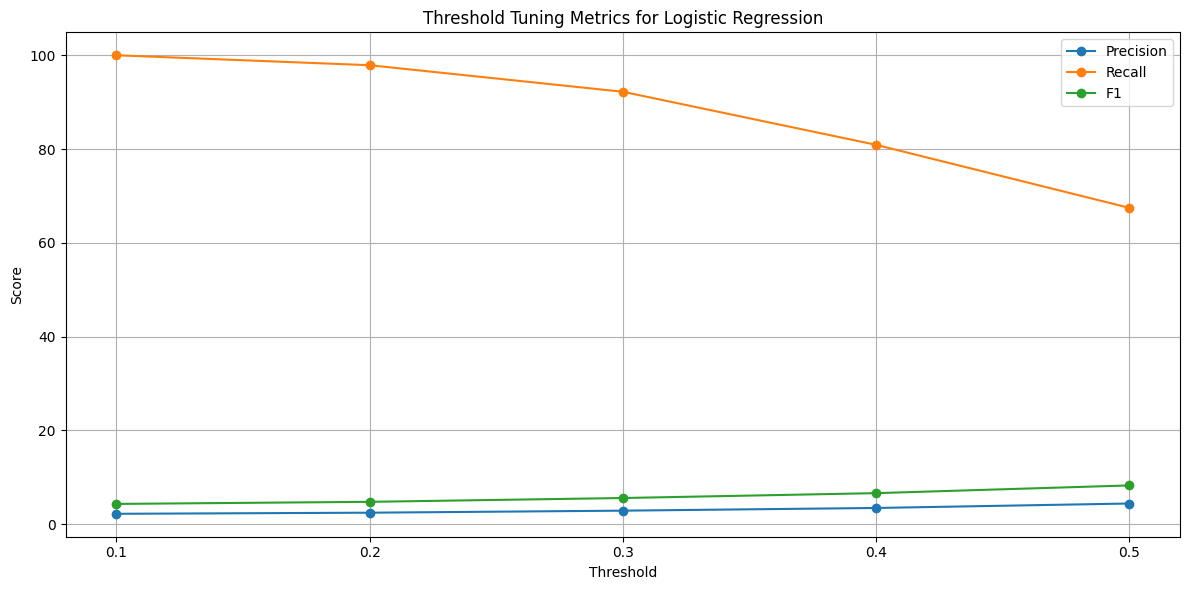

In [18]:
# === Visualization: Threshold Tuning ===
plt.figure(figsize=(12, 6))
for metric in ['Precision', 'Recall', 'F1']:
    plt.plot(df_threshold['Threshold'], df_threshold[metric], marker='o', label=metric)
plt.title('Threshold Tuning Metrics for Logistic Regression')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# CTR Improvement Calculation for Top Users (LogReg SMOTE Tuned, threshold 0.3)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
X_test_copy = X_test.copy()
X_test_copy['clicked'] = y_test
X_test_copy['proba'] = y_pred_proba
X_test_sorted = X_test_copy.sort_values('proba', ascending=False)

ctr_improvement_data = []

for pct in [10, 20, 30]:
    top_n = int(len(X_test_sorted) * (pct / 100))
    top_users = X_test_sorted.head(top_n)
    pred_ctr = (top_users['clicked'].sum() / top_n) * 100
    improvement = ((pred_ctr - ctr) / ctr) * 100
    ctr_improvement_data.append({
        'Top_Percent': pct,
        'Predicted_CTR': round(pred_ctr, 2),
        'Original_CTR': round(ctr, 2),
        'Improvement_%': round(improvement, 2)
    })

ctr_improvement_df = pd.DataFrame(ctr_improvement_data)
print("--- CTR Improvement Table ---")
print(ctr_improvement_df)

--- CTR Improvement Table ---
   Top_Percent  Predicted_CTR  Original_CTR  Improvement_%
0           10           7.05          2.12         232.70
1           20           5.10          2.12         140.68
2           30           4.52          2.12         113.15
